In [8]:
def radial2(gal, ext, xcen, ycen, rst, q, pa, delr=0.5, rmax=50, norm=True, rms=False):
    '''
    Parameters
    ----------
    ext : int
        Fits extension number
    delr : float
        in pixel
    rmax : float
        in pixel
    rcalc : float
        radius at which stellar mass is calculated.
    rms : bool
        is input a rms map?
    
    Returns
    -------
    r : float array
        radius. in pixel.
    f : float array
        flux, in units of counts/pixel.
        
    Notes
    -----
    Radius that is retured from this starts with delr/2.
    '''
    
    hdu = fits.open(gal)
    sci = hdu[ext].data[int(ycen-rst/2.):int(ycen+rst/2.)-1, int(xcen-rst/2.):int(xcen+rst/2.)-1]
    if rms:
        sci[:,:] = sci[:,:]**2
        
    hdu.close()
    if norm:
        sci /= np.sum(sci)

    rn = np.arange(0,rmax/delr,1)
    r  = rn * delr + delr/2.
    f  = r * 0
    n  = r * 0
    ef = r * 0
    fs = r * 0 # sky
    ns = r * 0

    fpeak = 0
    xcen1, ycen1 = rst/2., rst/2.

    flag = sci*0
    contmp = (flag == 0)
    flag_f = flag[contmp]
    xx = flag_f * 0
    yy = flag_f * 0
    rr = flag_f * 0

    contmp = (flag == 0)
    sci_f = sci[contmp]

    for jj in range(len(sci[:,0])):
        for ii in range(len(sci[0,:])):
            ji = jj*len(sci[:,0]) + ii
            xx[ji] = ii
            yy[ji] = jj

            if ii - xcen1 != 0:
                th = math.atan((jj-ycen1)/(ii-xcen1))
            elif (jj-ycen1)>0:
                th = pi/2.
            elif (jj-ycen1)<0:
                th = pi*3./2.

            Cq = get_ellipse_coords(a=1.0, b=q, x=0.0, y=0.0, angle=-pa+pi/2., theta=th) # Correction for axis ratio.
            rtmp = np.sqrt((jj-ycen1)**2 + (ii-xcen1)**2) * Cq

            rr[ji] = rtmp

    for kk in range(len(r)):
        conr = (rr >= r[kk]) & (rr < r[kk]+delr) &\
               (rr < rmax)
        f[kk] = np.sum(sci_f[conr])
        n[kk] = len(sci_f[conr])

        if n[kk]>0:
            f[kk] /= n[kk]

    if norm:
        sum = 0
        for kk in range(len(r)):
            if r[kk]<rmax:
                sum += 2 * np.pi * r[kk] * f[kk] * delr
        if sum>0:
            f /= sum
        else:
            print('Sum is %.2f'%(sum))
            print('Normalization failed.')

    if rms:
        f = np.sqrt(f)
            
    return r, f



In [9]:
def get_ellipse_coords(a=0.0, b=0.0, x=0.0, y=0.0, angle=0.0, theta=0):
    """ Draws an ellipse using (360*k + 1) discrete points; based on pseudo code
    given at http://en.wikipedia.org/wiki/Ellipse
    k = 1 means 361 points (degree by degree)
    a = major axis distance,
    b = minor axis distance,
    x = offset along the x-axis
    y = offset along the y-axis
    angle = clockwise rotation [in degrees] of the ellipse;
        * angle=0  : the ellipse is aligned with the positive x-axis
        * angle=30 : rotated 30 degrees clockwise from positive x-axis
    """

    beta = -angle * np.pi/180.0
    sin_beta = np.sin(beta)
    cos_beta = np.cos(beta)
    #alpha = np.radians(np.r_[0.:360.:1j*(360*k+1)])
    alpha = theta

    sin_alpha = np.sin(alpha)
    cos_alpha = np.cos(alpha)

    #pts[:, 0] = x + (a * cos_alpha * cos_beta - b * sin_alpha * sin_beta)
    #pts[:, 1] = y + (a * cos_alpha * sin_beta + b * sin_alpha * cos_beta)
    xx = x + (a * cos_alpha * cos_beta - b * sin_alpha * sin_beta)
    yy = y + (a * cos_alpha * sin_beta + b * sin_alpha * cos_beta)

    C = 1./np.sqrt(xx**2+yy**2)

    return C


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import os
from astropy.modeling.functional_models import Sersic1D as Ser
import matplotlib.cm as cm
import math
pi = np.pi

#import borgpipe as bp


In [7]:
hd0_gal

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  300 / Length of data axis 1                          
NAXIS2  =                  300 / Length of data axis 2                          
PCOUNT  =                    0 / number of random group parameters              
GCOUNT  =                    1 / number of random groups                        
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                150.0 / Pixel coordinate of reference point            
CRPIX2  =                150.0 / Pixel coordinate of reference point            
CD1_1   = -1.8333333333333E-05 / Coordinate transformation matrix element       
CD2_2   =  1.8333333333333E-05 / Coordinate transformation matrix element       
CDELT1  =                  1

In [4]:
ext = 1 # Observed profile;
gal = '2494_JWST_NIRISS_NIS_F200W_out.fits'
hd0_gal = fits.open(gal)[1].header

# For best fit params;
hd_gal = fits.open(gal)[2].header

hd_gal

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                  300 / Length of data axis 1                          
NAXIS2  =                  300 / Length of data axis 2                          
OBJECT  = 'model   '           / Component type                                 
COMMENT ========== GALFIT Input Parameters ==========                           
INITFILE= 'galfit//galfit/2494_JWST_NIRISS_NIS_F200W.galfit' / GALFIT input file
DATAIN  = 'galfit//cutout/2494_JWST_NIRISS_NIS_F200W_sci.fits' / Input data imag
SIGMA   = 'galfit//cutout/2494_JWST_NIRISS_NIS_F200W_rms.fits' / Input sigma ima
PSF     = 'psf_JWST_NIRISS_NIS_F200W.fits ' / Convolution PSF and kernel        
CONSTRNT= './gal_hr.cons'      / Parameter constraint file                      
MASK    = 'galfit//cutout/24

In [5]:
#@@@ If you do not have the following, find out from e.g., SExtractor catalog. 

xcen = float(hd_gal['2_XC'].split(' ')[0])
ycen = float(hd_gal['2_YC'].split(' ')[0])
rst = int(hd_gal['NAXIS1'])
q = float(hd_gal['2_AR'].split(' ')[0])
pa = float(hd_gal['2_PA'].split(' ')[0])
delr = 1.0

In [6]:
r, f = radial2(gal, ext, xcen, ycen, rst, q, pa, delr=delr, rmax=20, norm=False)

In [7]:
# RMS;
gal = '2494_JWST_NIRISS_NIS_F200W_rms.fits'
ext = 0
_, ef = radial2(gal, ext, xcen, ycen, rst, q, pa, delr=delr, rmax=20, norm=False, rms=True)


(26.0, 23.0)

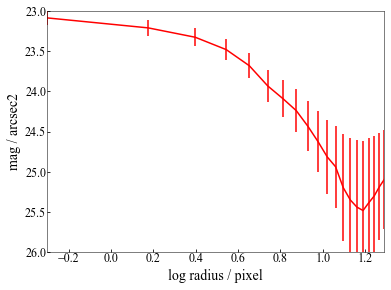

In [8]:
magzp = float(hd_gal['MAGZPT'])
pix = float(hd0_gal['CD1_1'])*3600 # pixel scale
area = pix**2 # arcsec2
f_phys = -2.5*np.log10(f / area) + magzp # mag / arcsec2
sn = f / ef
ef_phys = 1/sn # mag / arcsec2

plt.errorbar(np.log10(r), f_phys, yerr=ef_phys)
plt.xlabel('log radius / pixel')
plt.ylabel('mag / arcsec2')
plt.ylim(26, 23)